# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [20]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [21]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

# own classes
from utilities import reconstruct_sequential_data, train_test_split, extract_features_and_targets_reg, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [22]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

### Features

In [23]:
MOVING_AVERAGES = [50, 20]
MA_FEATURES = [f'{ma}d MA' for ma in MOVING_AVERAGES]
INCLUDE_MOVING_AVERAGES = False

FEATURES = ['Trend', 'Close', 'Log Close', 'Daily Returns Percent', 'Volume', 'mom', 'mom1', 'mom2', 'mom3', 'ROC_5',
       'ROC_10', 'ROC_15', 'ROC_20', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_200',
       'DTB4WK', 'DTB3', 'DTB6', 'DGS5', 'DGS10', 'Oil', 'Gold', 'DAAA',
       'DBAA', 'GBP', 'JPY', 'CAD', 'CNY', 'AAPL', 'AMZN', 'GE', 'JNJ', 'JPM',
       'MSFT', 'WFC', 'XOM', 'FCHI', 'FTSE', 'GDAXI', 'DJI', 'HSI', 'IXIC',
       'SSEC', 'RUT', 'NYSE', 'TE1', 'TE2', 'TE3', 'TE5', 'TE6', 'DE1', 'DE2',
       'DE4', 'DE5', 'DE6', 'CTB3M', 'CTB6M', 'CTB1Y', 'AUD', 'Brent',
       'CAC-F', 'copper-F', 'WIT-oil', 'DAX-F', 'DJI-F', 'EUR', 'FTSE-F',
       'gold-F', 'HSI-F', 'KOSPI-F', 'NASDAQ-F', 'GAS-F', 'Nikkei-F', 'NZD',
       'silver-F', 'RUSSELL-F', 'S&P-F', 'CHF', 'Dollar index-F',
       'Dollar index', 'wheat-F', 'XAG', 'XAU']

# FEATURES = ['Trend', 'AAPL', 'FTSE', 'Volume',
#             'Close', 'Gold', 'JNJ', 'Dollar index']

if INCLUDE_MOVING_AVERAGES:
    FEATURES += MA_FEATURES

### Hyperparams (ish)

In [24]:
BENCHMARK = False
RANDOM_LABEL_PERMUTATION = False
CLASSIFICATION = True


SEQ_LEN = 12
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
HIDDEN_SIZE = 4
NUM_LAYERS = 1

OUTPUT_LOGITS = True
BIDIRECTIONAL = True


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [26]:
if LOAD_ORIGINAL_DATA:
    # load and convert date column to datetime
    traffic = pd.read_csv(REAL_DATA_FOLDER / 'metro_interstate_traffic_volume_original.csv')
    traffic['date'] = pd.to_datetime(traffic['date'])

    # create a series with a full range of dates with hourly frequency
    # does take leap years and different month length into account
    full_range = pd.date_range(start=traffic['date'].min(), end=traffic['date'].max(), freq='H')

    traffic = traffic.drop_duplicates(subset='date') # drop duplicates
    traffic.set_index('date', inplace=True) # set date as index

    traffic = traffic.reindex(full_range, method='nearest') # reindex to full_range and fill missing values with nearest value

    # set index name and reset index to keep date as column
    traffic.index.name = 'date'
    traffic.reset_index(inplace=True)

else:
    
    traffic = pd.read_csv(REAL_DATA_FOLDER / 'metro_interstate_traffic_volume_filled.csv')
    traffic['date'] = pd.to_datetime(traffic['date'])

# only include data from 2015-07-01
# the reason is because the data before that date is not complete
traffic = traffic[traffic['date'] > '2015-07-01']

In [27]:
traffic.head()

,date,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
24040,2015-07-01 01:00:00,NaN,289.40,0.0,0.0,1,Clear,sky is clear,444
24041,2015-07-01 02:00:00,NaN,289.19,0.0,0.0,1,Clear,sky is clear,347
24042,2015-07-01 03:00:00,NaN,288.74,0.3,0.0,1,Rain,light rain,356
24043,2015-07-01 04:00:00,NaN,288.07,0.0,0.0,1,Clear,sky is clear,936
24044,2015-07-01 05:00:00,NaN,287.87,0.0,0.0,1,Clear,sky is clear,2886


### Preprocessing

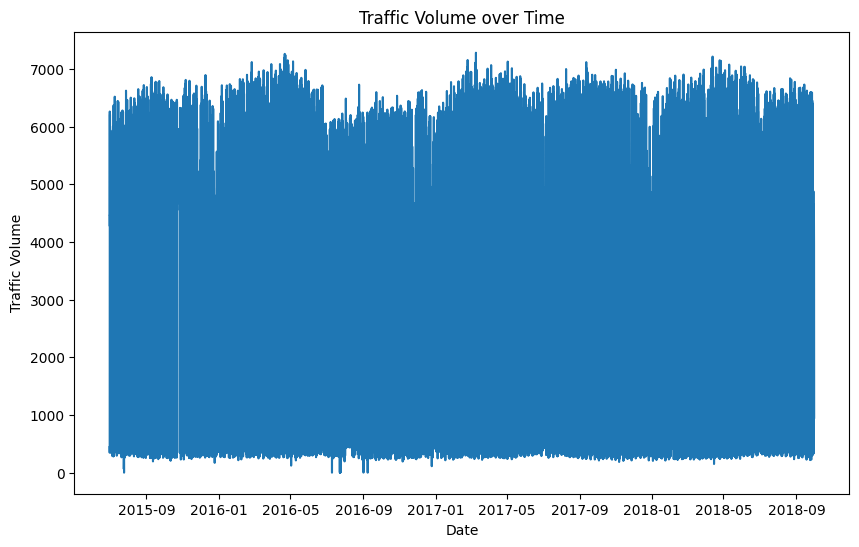

In [28]:
# plot traffic volume
plt.figure(figsize=(10, 6))
plt.plot(traffic['date'], traffic['traffic_volume'])
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume over Time')
plt.show()

## Feature Engineering

In [29]:
# Monat extrahieren
traffic['month'] = traffic['date'].dt.month

# one hot encoding for categorical variables
traffic = pd.get_dummies(traffic, columns=['weather_main', 'weather_description', 'month'], dtype=int)

# encode holiday as binary variable
traffic['holiday'] = traffic['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)

# encode weekend as binary variable
traffic['weekend'] = traffic['date'].apply(lambda x: 1 if x.day_of_week in [5, 6] else 0)

# encode hour as cyclic variable
traffic['hour'] = traffic['date'].dt.hour
traffic['hour_sin'] = np.sin((2 * np.pi * traffic['hour']) / 24)
traffic['hour_cos'] = np.cos((2 * np.pi * traffic['hour']) / 24)

# drop unnecessary columns
traffic.drop(columns=['date', 'hour'], inplace=True)

In [30]:
# extract columns which have to be scaled
traffic_volume = traffic.pop('traffic_volume')
temp = traffic.pop('temp')
clouds_all = traffic.pop('clouds_all')

# insert so that target is the first column
traffic.insert(0, 'clouds_all', clouds_all)
traffic.insert(0, 'temp', temp)
traffic.insert(0, 'traffic_volume', traffic_volume)

In [31]:
if CLASSIFICATION:
    traffic['traffic_volume_diff'] = traffic['traffic_volume'].diff()
    traffic_volume_diff = traffic.pop('traffic_volume_diff')
    traffic.insert(0, 'traffic_volume_diff', traffic_volume_diff)

    traffic.dropna(inplace=True)

    traffic['traffic_volume_diff'] = traffic['traffic_volume_diff'].apply(lambda x: 1 if x > 0 else 0)

In [32]:
traffic.head(20)

,traffic_volume_diff,traffic_volume,temp,clouds_all,holiday,rain_1h,snow_1h,weather_main_Clear,weather_main_Clouds,weather_main_Drizzle,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekend,hour_sin,hour_cos
24041,0,347,289.19,1,0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,5.000000e-01,8.660254e-01
24042,1,356,288.74,1,0,0.3,0.0,0,0,0,...,0,1,0,0,0,0,0,0,7.071068e-01,7.071068e-01
24043,1,936,288.07,1,0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,8.660254e-01,5.000000e-01
24044,1,2886,287.87,1,0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,9.659258e-01,2.588190e-01
24045,1,5741,287.38,1,0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,1.000000e+00,6.123234e-17
24046,1,6261,287.58,75,0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,9.659258e-01,-2.588190e-01
24047,0,4409,288.58,40,0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,8.660254e-01,-5.000000e-01
24048,0,4409,288.58,40,0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,7.071068e-01,-7.071068e-01
24049,0,4273,289.24,40,0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,5.000000e-01,-8.660254e-01
24050,1,4469,289.44,75,0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,2.588190e-01,-9.659258e-01


## Preprocessing

In [33]:
traffic_np = traffic.to_numpy()

In [34]:
traffic_train, traffic_test = train_test_split(traffic_np, FIRST_SPLIT)
traffic_test, traffic_val = train_test_split(traffic_test, SECOND_SPLIT)

In [53]:
traffic_train.shape, traffic_test.shape, traffic_val.shape

((22808, 66), (2851, 66), (2851, 66))

In [36]:
scaler = Scaler(traffic_train, no_features_to_scale = 4 if CLASSIFICATION else 3)

In [37]:
traffic_train_scaled = scaler.scale_data(traffic_train)
traffic_test_scaled = scaler.scale_data(traffic_test)
traffic_val_scaled = scaler.scale_data(traffic_val)

In [38]:
traffic_train_seq_scaled = split_data_into_sequences(traffic_train_scaled, SEQ_LEN)
traffic_test_seq_scaled = split_data_into_sequences(traffic_test_scaled, SEQ_LEN)
traffic_val_seq_scaled = split_data_into_sequences(traffic_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (22797, 12, 66)
Shape of the data after splitting into sequences: (2840, 12, 66)
Shape of the data after splitting into sequences: (2840, 12, 66)


In [39]:
if CLASSIFICATION:
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.MSELoss()

### Benchmarking methods

In [40]:
def create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val):
    # get baseline performance
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TimeSeriesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = TimeSeriesDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, val_loader

In [41]:
def train_model_once(no_features, train_loader, val_loader):
    # create and train model
    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=no_features,
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    _, _, _, _, model = train_model(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                verbose=False)
    
    return model

In [42]:
def get_test_performance(model, X_test, y_test):
    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

## Benchmark / Training

In [43]:
# get train, test and validation data
if CLASSIFICATION:
    print('Classification')
    X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(traffic_train_seq_scaled, traffic_test_seq_scaled, traffic_val_seq_scaled)
else:
    print('Regression')
    X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets_reg(traffic_train_seq_scaled, traffic_test_seq_scaled, traffic_val_seq_scaled)

Classification


In [63]:
if BENCHMARK:
        
    results = pd.DataFrame(columns=['Feature', 'Metric', 'Value'])
    test_accs = []
    test_losses = []

    for i in range(5):
        # get baseline performance
        train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val)
        trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
        test_acc, test_loss = get_test_performance(trained_model, X_test, y_test)

        test_accs.append(test_acc)
        test_losses.append(test_loss)

    # save baseline performance
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Loss', 'Value': np.mean(np.array(test_losses))}])], ignore_index=True)

    for feature in FEATURES[1:]:

        print(f'Current feature: {feature}')
        test_accs = []
        test_losses = []

        for i in range(5):
            print(f'Iteration {i+1}')

            # random permutation of one specific feature
            feature_index = FEATURES.index(feature)-1 # -1 because of the trend feature
            permuted_X_test = dc(X_test)
            permuted_X_test[:, :, feature_index] = torch.tensor(np.random.permutation(permuted_X_test[:, :, feature_index]), dtype=torch.float32)

            train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, permuted_X_test, y_test, X_val, y_val)
            trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
            test_acc, test_loss = get_test_performance(trained_model, permuted_X_test, y_test)

            test_accs.append(test_acc)
            test_losses.append(test_loss)

        # save performance
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Loss', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)

else:
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    val_dataset = TimeSeriesDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    if CLASSIFICATION:
        print('Using BCEWithLogitsLoss for classification')
        criterion = nn.BCEWithLogitsLoss()
    else:
        print('Using MSELoss for regression')
        criterion = nn.MSELoss()
        
    val_losses = []
    val_accs = []
    train_losses = []
    train_accs = []

    model = LSTMClassification(
            device=device,
            batch_size = BATCH_SIZE,
            input_size=X_train.shape[2], # number of features
            hidden_size=HIDDEN_SIZE,
            num_stacked_layers=NUM_LAYERS,
            bidirectional=BIDIRECTIONAL,
            output_logits=OUTPUT_LOGITS
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=device,
                        verbose=True)

Using BCEWithLogitsLoss for classification
Epoch: 1
Training Loss: 0.6793346866965294
Training Loss: 0.6890949791669846
Training Loss: 0.6912445551156998
Validation Loss: 0.6852712557556924
Validation Accuracy: 56.00421348314607
**************************************************
Epoch: 2
Training Loss: 0.6674977868795395
Training Loss: 0.6807410138845443
Training Loss: 0.683688525557518
Validation Loss: 0.6766304929604691
Validation Accuracy: 56.00421348314607
**************************************************
Epoch: 3
Training Loss: 0.6552615609765052
Training Loss: 0.6703122293949128
Training Loss: 0.6719454270601273
Validation Loss: 0.6619525283909915
Validation Accuracy: 56.00421348314607
**************************************************
Epoch: 4
Training Loss: 0.6389263129234314
Training Loss: 0.6534709832072259
Training Loss: 0.6513625028729438
Validation Loss: 0.6373126667537047
Validation Accuracy: 57.57256554307116
**************************************************
Epoch: 5
T

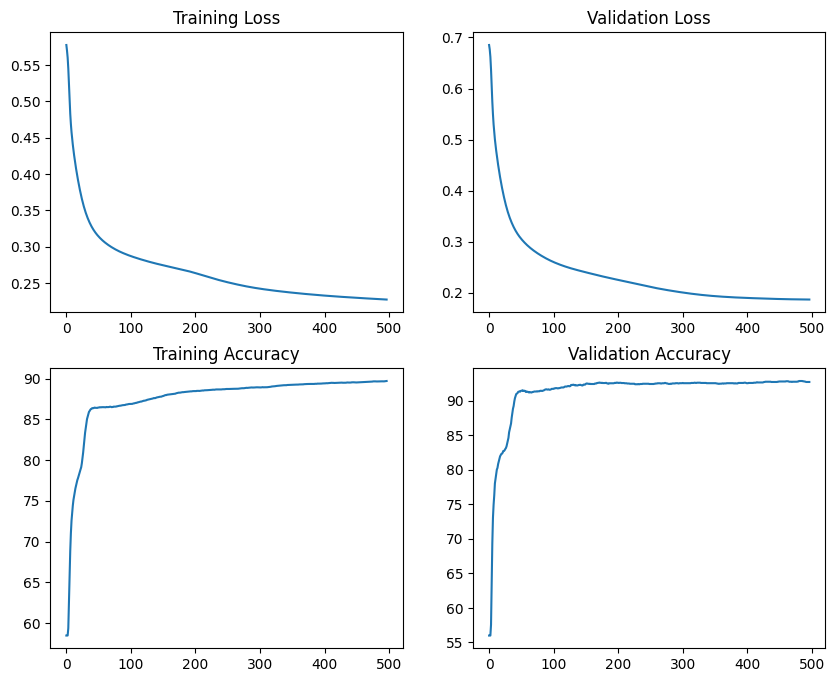

In [66]:
if BENCHMARK:

    # Erstelle eine Pivot-Tabelle, um die Daten besser zu handhaben
    pivot_df = results.pivot(index='Feature', columns='Metric', values='Value')

    # Sortiere die Daten nach den Accuracy-Werten
    pivot_df = pivot_df.sort_values(by='Accuracy', ascending=False)

    # Anzahl der Features
    num_features = len(pivot_df.index)

    # Initialisiere die Hauptfigur und die Hauptachse
    fig, ax1 = plt.subplots(figsize=(10, num_features * 0.4))  # Höhe proportional zur Anzahl der Features

    # Balkenbreite
    bar_height = 0.35

    # Positionen der Balken
    r1 = np.arange(len(pivot_df.index))
    r2 = [x + bar_height for x in r1]

    # Balken für Accuracy
    accuracy_bars = ax1.barh(r1, pivot_df['Accuracy'], color='skyblue', height=bar_height, label='Accuracy')

    # Zweite y-Achse für Loss
    ax2 = ax1.twiny()
    loss_bars = ax2.barh(r2, pivot_df['Loss'], color='salmon', height=bar_height, label='Loss')

    # Titel und Achsenbeschriftungen hinzufügen
    ax1.set_title('Feature Importance: Accuracy and Loss', fontsize=16)
    ax1.set_ylabel('Feature', fontsize=14)
    ax1.set_xlabel('Accuracy', fontsize=14, color='skyblue')
    ax2.set_xlabel('Loss', fontsize=14, color='salmon')

    # y-Ticks setzen
    ax1.set_yticks([r + bar_height/2 for r in range(len(pivot_df.index))])
    ax1.set_yticklabels(pivot_df.index)

    # Achsenbeschriftungen einfärben
    ax1.tick_params(axis='x', labelcolor='skyblue')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # Legenden kombinieren
    bars = accuracy_bars + loss_bars
    labels = [bar.get_label() for bar in bars]
    ax1.legend(bars, labels, loc='lower right')

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

else:
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
    axs[0, 0].plot(train_losses, label="MSELoss")
    axs[0, 0].set_title('Training Loss')

    axs[0, 1].plot(val_losses, label="MSELoss")
    axs[0, 1].set_title('Validation Loss')

    axs[1, 0].plot(train_accs, label="Accuracy")
    axs[1, 0].set_title('Training Accuracy')

    axs[1, 1].plot(val_accs, label="Accuracy")
    axs[1, 1].set_title('Validation Accuracy')

In [69]:
if CLASSIFICATION:
    acc, loss = get_test_performance(model, X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {acc}')

else:
    with torch.inference_mode(): 
        test_preds = model(X_test.to(device)) # get plain model output (logits)

Test Loss: 0.21384872496128082
Test Accuracy: 92.5


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_46649/3543369078.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))


In [70]:
if not CLASSIFICATION:
    start = 350
    end = start + 24*7

    # plot actual vs predicted traffic volume
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[start:end], label='Actual Values', color='b')
    plt.plot(test_preds[start:end], label='Predictions', color='r', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Traffic Volume')
    plt.title('Actual vs Predicted Traffic Volume')
    plt.legend()
    plt.show()

    # plot last feature vs predicted traffic volume
    plt.figure(figsize=(14, 7))
    plt.plot(X_test[start:end, -1, 0], label='Last Value From Feature', color='b')
    plt.plot(test_preds[start:end], label='Predictions', color='r', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Traffic Volume')
    plt.title('Last Feature Traffic Volume vs Predicted Traffic Volume')
    plt.legend()
    plt.show()



    # calculate cross-correlation
    def cross_correlation(x, y):
        correlation = torch.nn.functional.conv1d(
            x.unsqueeze(0).unsqueeze(0), 
            y.flip(0).unsqueeze(0).unsqueeze(0),
            padding=x.size(0) - 1
        ).squeeze().numpy()
        lags = np.arange(-(x.size(0) - 1), x.size(0))
        return correlation, lags

    correlation, lags = cross_correlation(test_preds[start:start+5].flatten(), X_test[start:start+5, -1, 0])

    # plot cross-correlation
    plt.figure(figsize=(14, 7))
    plt.plot(lags, correlation, label='Cross-Correlation', color='b')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation between Predictions and Feature')
    plt.legend()
    plt.grid(True)
    plt.show()